In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import os
from urllib.request import urlretrieve
import gzip
import math

In [2]:
# seeding for reproducibility
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)

In [ ]:
# Loading the FashionMNIST dataset
class FashionMNISTDataset:
    def __init__(self, root="./data", train=True, transform=None):
        self.root = root
        self.train = train
        self.transform = transform

        if not os.path.exists(self.root):
            os.makedirs(self.root)

        self.train_data_file = os.path.join(self.root, "train-images-idx3-ubyte.gz")
        self.train_labels_file = os.path.join(self.root, "train-labels-idx1-ubyte.gz")
        self.test_data_file = os.path.join(self.root, "t10k-images-idx3-ubyte.gz")
        self.test_labels_file = os.path.join(self.root, "t10k-labels-idx1-ubyte.gz")

        self.download_data()

        # load the dataset
        if self.train:
            self.data = self.load_images(self.train_data_file)
            self.targets = self.load_labels(self.train_labels_file)
        else:
            self.data = self.load_images(self.test_data_file)
            self.targets = self.load_labels(self.test_labels_file)

    def download_data(self):
        base_url = "http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/"

        files = {
            "train_data": ("train-images-idx3-ubyte.gz", self.train_data_file),
            "train_labels": ("train-labels-idx1-ubyte.gz", self.train_labels_file),
            "test_data": ("t10k-images-idx3-ubyte.gz", self.test_data_file),
            "test_labels": ("t10k-labels-idx1-ubyte.gz", self.test_labels_file),
        }

        for file_name, (url_file, local_file) in files.items():
            if not os.path.exists(local_file):
                print(f"Downloading {url_file}...")
                urlretrieve(base_url + url_file, local_file)

    def load_images(self, file_path):
        with gzip.open(file_path, "rb") as f:
            # remove the header (16 bytes)
            images = np.frombuffer(f.read(), dtype=np.uint8, offset=16).reshape(-1, 784)
            return images

    def load_labels(self, file_path):
        with gzip.open(file_path, "rb") as f:
            # remove the header (8 bytes)
            labels = np.frombuffer(f.read(), dtype=np.uint8, offset=8)
            return labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img, target = self.data[idx], self.targets[idx]

        img = img.astype(np.float32) / 255.0  # Normalize to [0, 1]

        if self.transform:
            img = self.transform(img)
        else:
            img = torch.tensor(img, dtype=torch.float32)
        return img, target

Current working directory: d:\Study\Personal\Projects\ml-playground


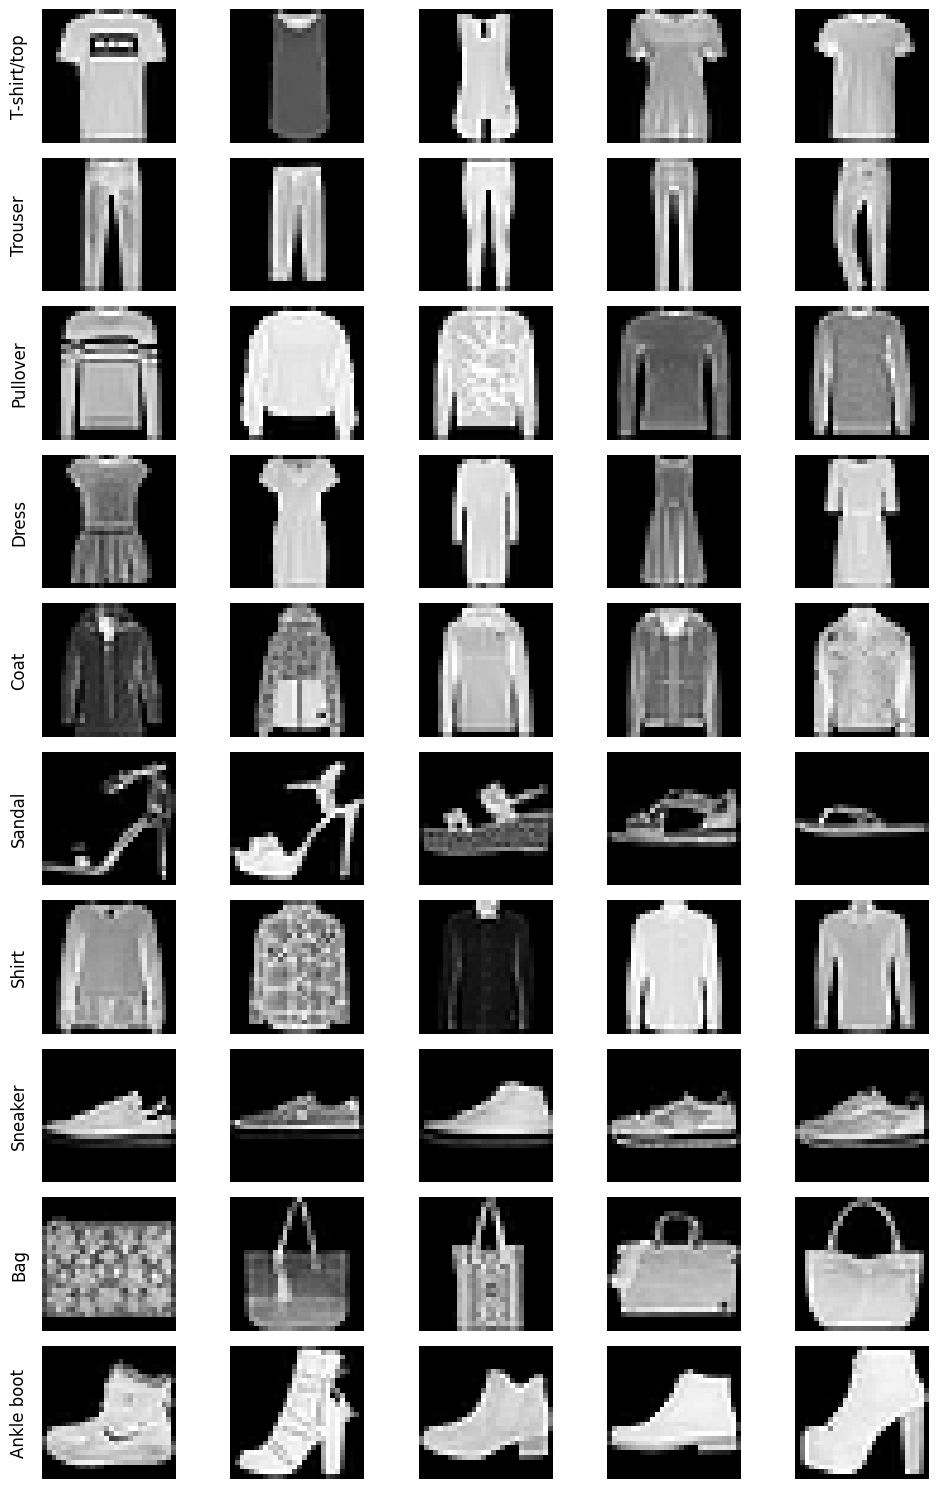

In [ ]:
root_dir = os.getcwd()
print(f"Current working directory: {root_dir}")

dataset = FashionMNISTDataset(root=os.path.join(root_dir, "data"), train=True)

classes = {
    "T-shirt/top": 0,
    "Trouser": 1,
    "Pullover": 2,
    "Dress": 3,
    "Coat": 4,
    "Sandal": 5,
    "Shirt": 6,
    "Sneaker": 7,
    "Bag": 8,
    "Ankle boot": 9,
}

n_images_per_class = 5
fig, axes = plt.subplots(nrows=len(classes), ncols=n_images_per_class, figsize=(10, 15))
for i, (class_name, class_idx) in enumerate(classes.items()):
    class_images = [
        dataset[j][0].numpy().reshape(28, 28)
        for j in range(len(dataset))
        if dataset[j][1] == class_idx
    ]
    for j in range(n_images_per_class):
        axes[i, j].imshow(class_images[j], cmap="gray")
        axes[i, j].set_xticks([])
        axes[i, j].set_yticks([])
        axes[i, j].spines["top"].set_visible(False)
        axes[i, j].spines["right"].set_visible(False)
        axes[i, j].spines["bottom"].set_visible(False)
        axes[i, j].spines["left"].set_visible(False)

    axes[i, 0].set_ylabel(class_name, rotation=90, size="large", labelpad=10)
plt.subplots_adjust(left=0.2)
plt.tight_layout()
plt.show()

In [ ]:
# Custom Dataloader
class DataLoader:
    def __init__(self, dataset, batch_size=32, shuffle=False):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.n_samples = len(dataset)

    def __iter__(self):
        self.index = 0
        self.indices = np.arange(self.n_samples)
        if self.shuffle:
            np.random.shuffle(self.indices)
        return self

    def __next__(self):
        if self.index >= self.n_samples:
            raise StopIteration

        batch_indices = self.indices[
            self.index : min(self.index + self.batch_size, self.n_samples)
        ]
        self.index += self.batch_size

        batch_x = []
        batch_y = []
        for idx in batch_indices:
            x, y = self.dataset[idx]
            batch_x.append(x)
            batch_y.append(y)

        # stack tensors
        batch_x = torch.stack(batch_x)
        batch_y = torch.tensor(batch_y, dtype=torch.long)

        return batch_x, batch_y

    def __len__(self):
        return math.ceil(self.n_samples / self.batch_size)


# Example usage
train_loader = DataLoader(dataset, batch_size=64, shuffle=True)
print(f"Number of batches in train loader: {len(train_loader)}")
for batch_x, batch_y in train_loader:
    print(
        f"Batch size: {batch_x.size(0)}, Image shape: {batch_x.shape}, Labels shape: {batch_y.shape}"
    )
    break

Number of batches in train loader: 938
Batch size: 64, Image shape: torch.Size([64, 784]), Labels shape: torch.Size([64])


In [ ]:
class CVAE(nn.Module):
    def __init__(self, input_dim=784, hidden_dim=400, latent_dim=20, num_classes=10):
        super(CVAE, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.latent_dim = latent_dim
        self.num_classes = num_classes

        # Encoder
        self.fc1 = nn.Linear(input_dim + num_classes, hidden_dim)
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)  # Mean
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)  # Log variance

        # Decoder
        self.fc2 = nn.Linear(latent_dim + num_classes, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, input_dim)

    def encode(self, x, condition):
        x_c = torch.cat((x, condition), dim=1)  # Concatenate input and condition
        h = F.relu(self.fc1(x_c))
        h = F.relu(self.fc1(x_c))
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        # reparameterization trick
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        z = mu + eps * std
        return z

    def decode(self, z, condition):
        z_c = torch.cat(
            (z, condition), dim=1
        )  # Concatenate latent vector and condition
        h = F.relu(self.fc2(z_c))
        x_recon = torch.sigmoid(self.fc3(h))
        return x_recon

    def forward(self, x, condition):
        mu, logvar = self.encode(x, condition)
        z = self.reparameterize(mu, logvar)
        x_recon = self.decode(z, condition)
        return x_recon, mu, logvar


def loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x, reduction="sum")
    # mse = F.mse_loss(recon_x, x, reduction='mean')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD, BCE, KLD


In [ ]:
# one hot encoding for class labels
def one_hot_encode(labels, num_classes):
    device = labels.device
    labels = labels.long()
    one_hot = torch.zeros(labels.size(0), num_classes, device=device)
    one_hot.scatter_(dim=1, index=labels.unsqueeze(1), value=1)
    return one_hot


# e.g
for batch_x, batch_y in train_loader:
    condition = one_hot_encode(batch_y, 10)
    print(f"Value of batch_y: \n{batch_y}")
    print(f"Value of condition: \n{condition}")
    break


Value of batch_y: 
tensor([1, 0, 2, 1, 7, 0, 6, 3, 0, 1, 4, 2, 6, 6, 8, 8, 7, 6, 5, 9, 0, 9, 4, 4,
        7, 5, 4, 8, 9, 0, 9, 0, 2, 3, 7, 1, 3, 5, 8, 4, 7, 4, 1, 9, 3, 1, 1, 4,
        7, 5, 6, 1, 5, 6, 5, 0, 5, 3, 4, 8, 8, 6, 6, 2])
Value of condition: 
tensor([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1.

In [ ]:
class Logger:
    def __init__(self):
        self.train_total_losses = []
        self.train_bce_losses = []
        self.train_kl_losses = []
        self.test_total_losses = []
        self.test_bce_losses = []
        self.test_kl_losses = []
        self.epochs = []

    def log(self, epoch, total_loss, bce_loss, kl_loss):
        if epoch not in self.epochs:
            self.epochs.append(epoch)
        self.train_total_losses.append(total_loss)
        self.train_bce_losses.append(bce_loss)
        self.train_kl_losses.append(kl_loss)

    def log_test(self, epoch, total_loss, bce_loss, kl_loss):
        self.test_total_losses.append(total_loss)
        self.test_bce_losses.append(bce_loss)
        self.test_kl_losses.append(kl_loss)

    def plot_losses(self):
        fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 5))

        # Plot total loss
        axes[0].plot(
            self.epochs, self.train_total_losses, "b-", marker="o", label="Train"
        )
        if len(self.test_total_losses) > 0:
            axes[0].plot(
                self.epochs, self.test_total_losses, "r-", marker="s", label="Test"
            )
        axes[0].set_xlabel("Epoch")
        axes[0].set_ylabel("Loss")
        axes[0].set_title("Total Loss")
        axes[0].legend()
        axes[0].grid(True)

        # Plot BCE loss
        axes[1].plot(
            self.epochs, self.train_bce_losses, "b-", marker="o", label="Train"
        )
        if len(self.test_bce_losses) > 0:
            axes[1].plot(
                self.epochs, self.test_bce_losses, "r-", marker="s", label="Test"
            )
        axes[1].set_xlabel("Epoch")
        axes[1].set_ylabel("Loss")
        axes[1].set_title("BCE Loss")
        axes[1].legend()
        axes[1].grid(True)

        # Plot KL loss
        axes[2].plot(self.epochs, self.train_kl_losses, "b-", marker="o", label="Train")
        if len(self.test_kl_losses) > 0:
            axes[2].plot(
                self.epochs, self.test_kl_losses, "r-", marker="s", label="Test"
            )
        axes[2].set_xlabel("Epoch")
        axes[2].set_ylabel("Loss")
        axes[2].set_title("KL Loss")
        axes[2].legend()
        axes[2].grid(True)

        plt.tight_layout()
        plt.show()


def train(model, device, train_loader, optimizer, epoch, logger):
    model.train()
    train_loss = 0
    bce_loss_sum = 0
    kld_loss_sum = 0
    num_batches = 0

    for batch_idx, (data, labels) in enumerate(train_loader):
        data = data.to(device)
        labels = labels.to(device)

        # one hot encoding the labels
        labels_one_hot = one_hot_encode(labels, num_classes=10)

        optimizer.zero_grad()

        recon_batch, mu, logvar = model(data, labels_one_hot)
        loss, bce, kl = loss_function(recon_batch, data, mu, logvar)

        loss.backward()
        train_loss += loss.item()
        bce_loss_sum += bce.item()
        kld_loss_sum += kl.item()
        num_batches += 1
        optimizer.step()

        if batch_idx % 100 == 0:
            print(
                f"Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} "
                f"({100.0 * batch_idx / len(train_loader):.0f}%)]\t"
                f"Loss: {loss.item() / len(data):.6f} "
                f"(BCE: {bce.item() / len(data):.6f}, KL: {kl.item() / len(data):.6f})"
            )

    avg_loss = train_loss / len(train_loader.dataset)
    avg_bce = bce_loss_sum / len(train_loader.dataset)
    avg_kld = kld_loss_sum / len(train_loader.dataset)
    logger.log(epoch, avg_loss, avg_bce, avg_kld)

    print(
        f"====> Epoch: {epoch} Average loss: {avg_loss:.4f} "
        f"(BCE: {avg_bce:.4f}, KL: {avg_kld:.4f})"
    )


def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    test_bce = 0
    test_kld = 0

    with torch.no_grad():
        for data, labels in test_loader:
            data = data.to(device)
            labels = labels.to(device)

            # One-hot encode the labels
            labels_one_hot = one_hot_encode(labels, num_classes=10)

            recon_batch, mu, logvar = model(data, labels_one_hot)

            loss, bce, kld = loss_function(recon_batch, data, mu, logvar)

            test_loss += loss.item()
            test_bce += bce.item()
            test_kld += kld.item()

    test_loss /= len(test_loader.dataset)
    test_bce /= len(test_loader.dataset)
    test_kld /= len(test_loader.dataset)

    print(
        f"====> Test set loss: {test_loss:.4f} "
        f"(BCE: {test_bce:.4f}, KL: {test_kld:.4f})"
    )

    return test_loss, test_bce, test_kld

In [ ]:
def generate_images(model, device, label_idx, num_images=10):
    model.eval()
    with torch.no_grad():
        # Create one-hot encoded label
        label = one_hot_encode(
            torch.tensor([label_idx] * num_images, device=device), 10
        )

        # Sample from latent space
        z = torch.randn(num_images, model.latent_dim).to(device)

        # Decode
        sample = model.decode(z, label)

        return sample.view(num_images, 28, 28)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")


class Normalize:
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, img):
        return (img - self.mean) / self.std


train_dataset = FashionMNISTDataset(root=os.path.join(root_dir, "data"), train=True)
test_dataset = FashionMNISTDataset(root=os.path.join(root_dir, "data"), train=False)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

model = CVAE().to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-3)
logger = Logger()

classes = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]

epochs = 50
for epoch in range(1, epochs + 1):
    train(model, device, train_loader, optimizer, epoch, logger)
    test_loss, test_bce, test_kld = test(model, device, test_loader)
    logger.log_test(epoch, test_loss, test_bce, test_kld)


Device: cuda
Train Epoch: 1 [0/60000 (0%)]	Loss: 547.110107 (BCE: 546.968262, KL: 0.141871)
Train Epoch: 1 [12800/60000 (21%)]	Loss: 284.405609 (BCE: 271.048187, KL: 13.357422)
Train Epoch: 1 [25600/60000 (43%)]	Loss: 276.013824 (BCE: 262.632324, KL: 13.381493)
Train Epoch: 1 [38400/60000 (64%)]	Loss: 279.327545 (BCE: 264.772522, KL: 14.555029)
Train Epoch: 1 [51200/60000 (85%)]	Loss: 263.082031 (BCE: 249.703751, KL: 13.378266)
====> Epoch: 1 Average loss: 283.2338 (BCE: 270.0978, KL: 13.1360)
====> Test set loss: 260.4105 (BCE: 247.0494, KL: 13.3611)
Train Epoch: 2 [0/60000 (0%)]	Loss: 259.096130 (BCE: 245.707825, KL: 13.388319)
Train Epoch: 2 [12800/60000 (21%)]	Loss: 249.357758 (BCE: 235.890930, KL: 13.466830)
Train Epoch: 2 [25600/60000 (43%)]	Loss: 258.561279 (BCE: 245.052399, KL: 13.508869)
Train Epoch: 2 [38400/60000 (64%)]	Loss: 264.435425 (BCE: 251.265625, KL: 13.169786)
Train Epoch: 2 [51200/60000 (85%)]	Loss: 253.448868 (BCE: 239.419113, KL: 14.029750)
====> Epoch: 2 Average

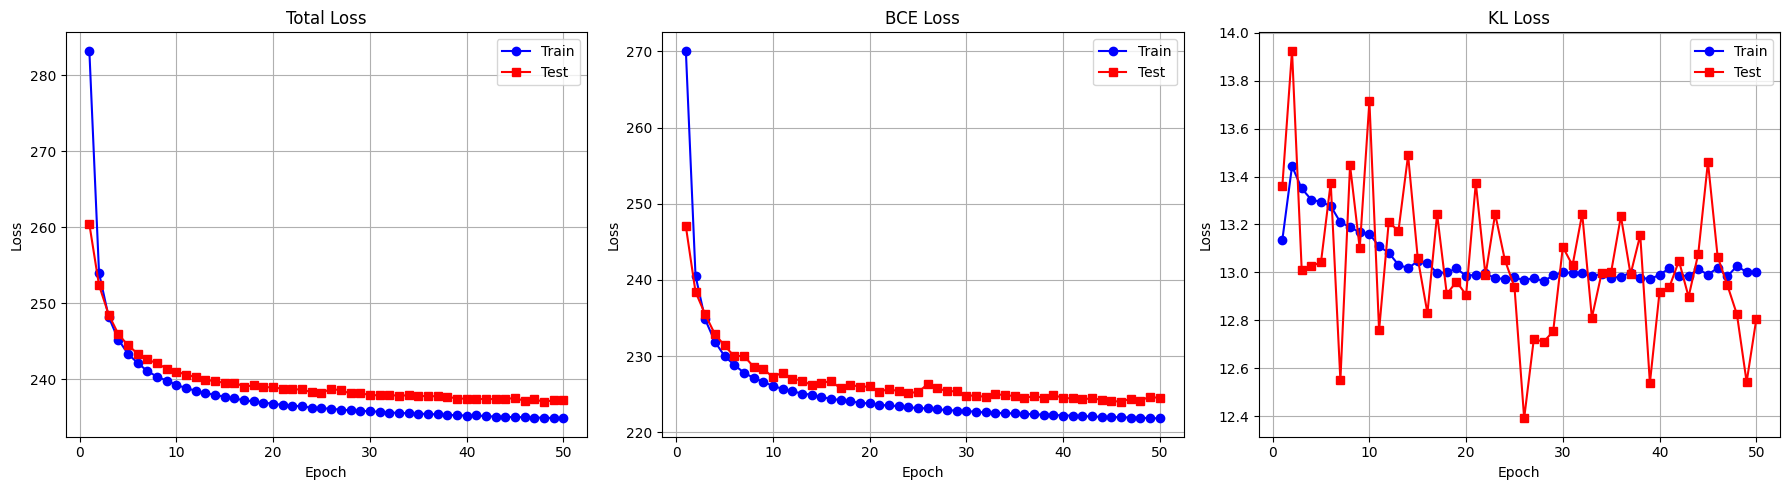

In [11]:
logger.plot_losses()

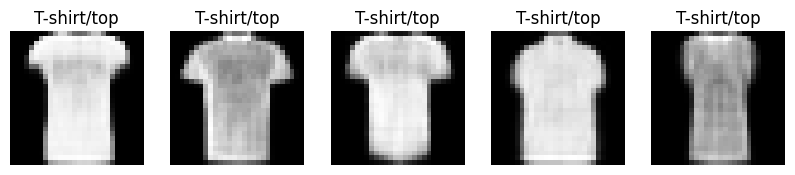

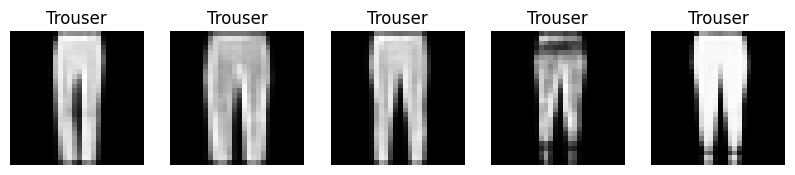

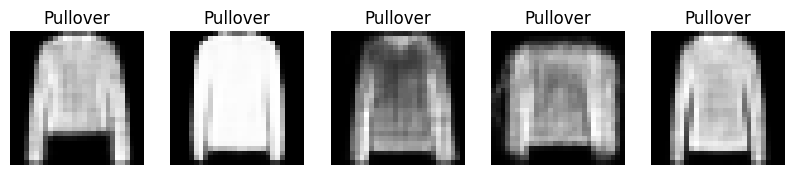

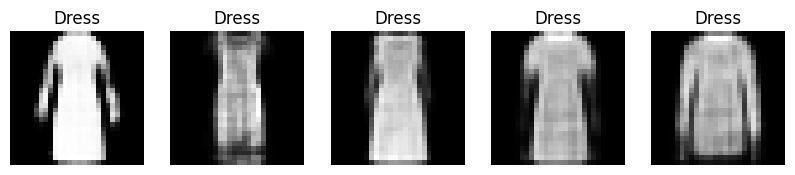

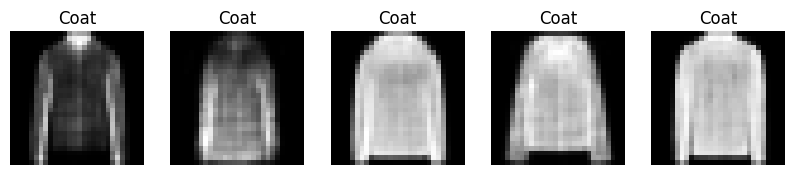

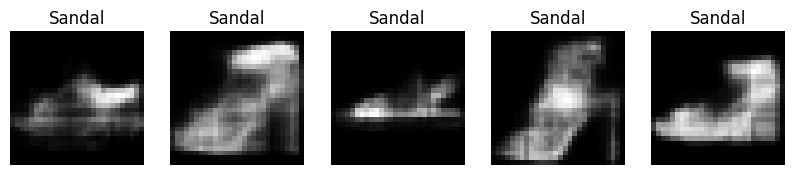

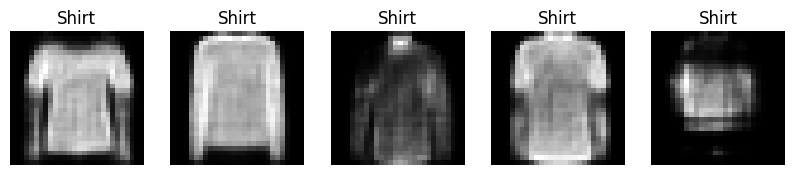

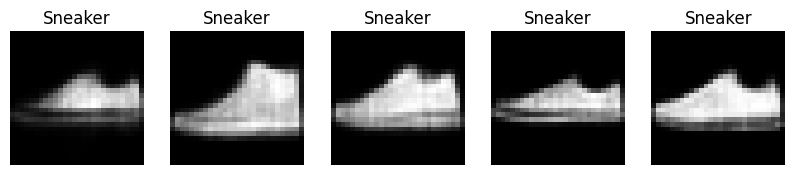

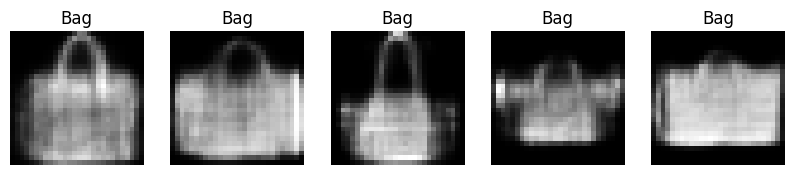

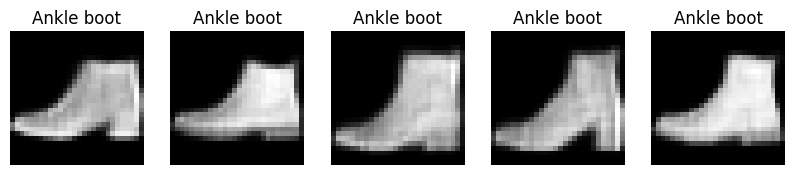

In [ ]:
for i in range(10):
    samples = generate_images(model, device, i)

    plt.figure(figsize=(10, 3))
    for j in range(5):
        plt.subplot(1, 5, j + 1)
        plt.imshow(samples[j].cpu().numpy(), cmap="gray")
        plt.title(classes[i])
        plt.axis("off")

    plt.show()